Лабораторная работа 3.

Деревья решений. Ансамбли решающих деревьев.

1. Выбрать подходящую таблицу данных. Построить и визуализировать дерево решений.

2. Применить метод градиентного бустинга. Вычислить значимость переменных. Выдать список построенных деревьев.

3. Построить зависимость качества решения (на обучении и скользящем контроле) от числа вершин дерева.

4. Для метода градиентного бустинга построить зависимость качества решения (на обучении и скользящем контроле) от числа деревьев.
Для разной глубины дерева нужно построить несколько зависимостей качества от числа деревьев, чтобы найти оптимальную комбинацию этих параметров.

5. Выполнить предыдущий пункт для случайного леса. Сравнить оценку out-of-bag с оценкой по кроссвалидации.


1. Data Preparation

Load and split the Wine dataset

*   Uses scikit-learn's Wine dataset (classification problem)

*   70-30 train-test split with stratification

*   Prints dataset characteristics

- Features: 13 numerical attributes
- Target: 3 classes (wine types)
- Moderate size (178 samples)


In [ ]:
# 1. Data Preparation
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

wine = load_wine()
X, y = wine.data, wine.target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
print(f"Features: {wine.feature_names}\nClasses: {wine.target_names}")
print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

Features: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
Classes: ['class_0' 'class_1' 'class_2']
Train size: 124, Test size: 54


2. Decision Tree

   Build/visualize tree, count nodes:

*   Uses entropy for splitting criterion

*   Visualizes first 3 levels of the tree

*   Calculates total nodes and test accuracy

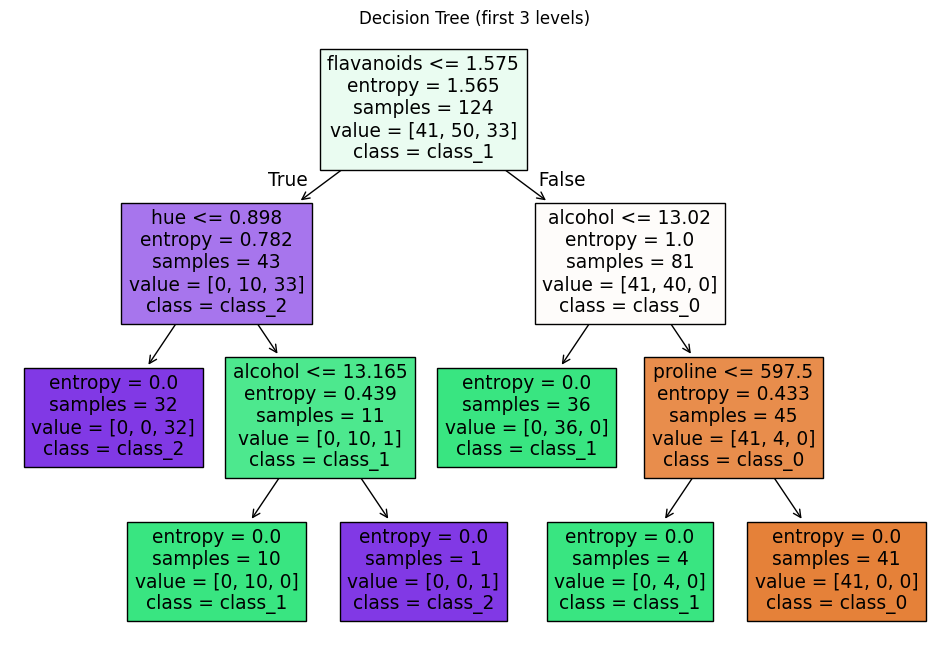

Total nodes: 11
Test accuracy: 0.907


In [ ]:
# 2. Decision Tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

dt = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt.fit(X_train, y_train)

plt.figure(figsize=(12,8))
plot_tree(dt, filled=True, feature_names=wine.feature_names,
          class_names=wine.target_names, max_depth=3)
plt.title("Decision Tree (first 3 levels)")
plt.show()

print(f"Total nodes: {dt.tree_.node_count}")
print(f"Test accuracy: {dt.score(X_test, y_test):.3f}")

3. Gradient Boosting
Implement boosting, feature importance, show trees

- Uses 100 estimators with learning rate 0.1

- Plots feature importance using MDI (Mean Decrease Impurity)

- Visualizes first tree in the ensemble

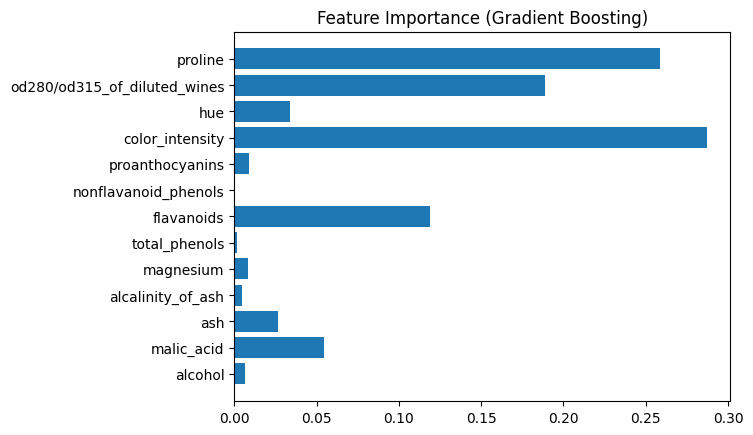

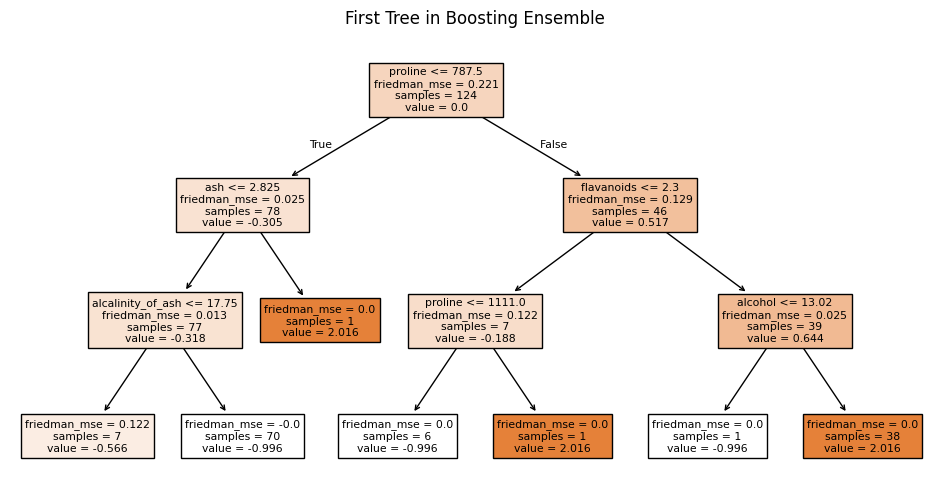

In [ ]:
# 3. Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,                 # Number of sequential trees = 100
                               random_state=42)
gb.fit(X_train, y_train)

# Feature importance
plt.barh(wine.feature_names, gb.feature_importances_)
plt.title("Feature Importance (Gradient Boosting)")
plt.show()

# First tree visualization
plt.figure(figsize=(12,6))
plot_tree(gb.estimators_[0, 0], filled=True, feature_names=wine.feature_names)
plt.title("First Tree in Boosting Ensemble")
plt.show()

4. Node Count Analysis

Study accuracy vs. tree complexity:

- Tests depths 1-10:
  - tree.tree_.node_count => total nodes in the tree (complexity measure):
    - Underfitting (depth=1): Low train/test accuracy.
    - Overfitting (depth>5): High train accuracy but dropping test accuracy

- Tracks training/test accuracy and node count

- Shows overfitting trend with deeper trees

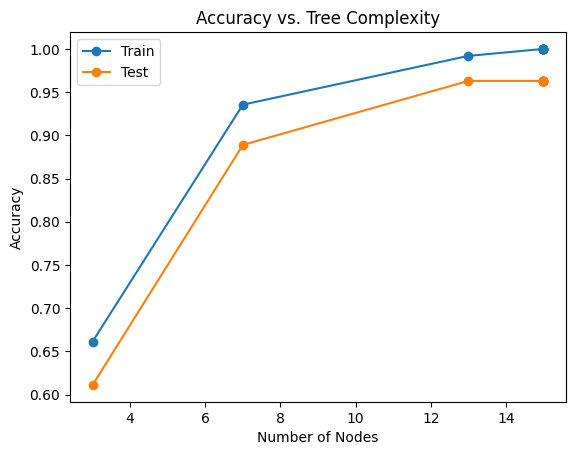

In [ ]:
# 4. Node Count Analysis
depths = range(1, 11)
train_acc, test_acc, nodes = [], [], []

for d in depths:
    tree = DecisionTreeClassifier(max_depth=d, random_state=42)
    tree.fit(X_train, y_train)
    train_acc.append(tree.score(X_train, y_train))
    test_acc.append(tree.score(X_test, y_test))
    nodes.append(tree.tree_.node_count)       # tree.tree_.node_count => total nodes in the tree (complexity measure)

plt.plot(nodes, train_acc, 'o-', label='Train')
plt.plot(nodes, test_acc, 'o-', label='Test')
plt.xlabel("Number of Nodes"), plt.ylabel("Accuracy")
plt.title("Accuracy vs. Tree Complexity"), plt.legend()
plt.show()

5. Boosting Learning Curves
Analyze boosting performance vs. n_estimators:

- Optimize depth and tree count.

- Tests 4 different tree depths (2-5)

- Uses 5-fold cross-validation

- Shows learning curves for each depth

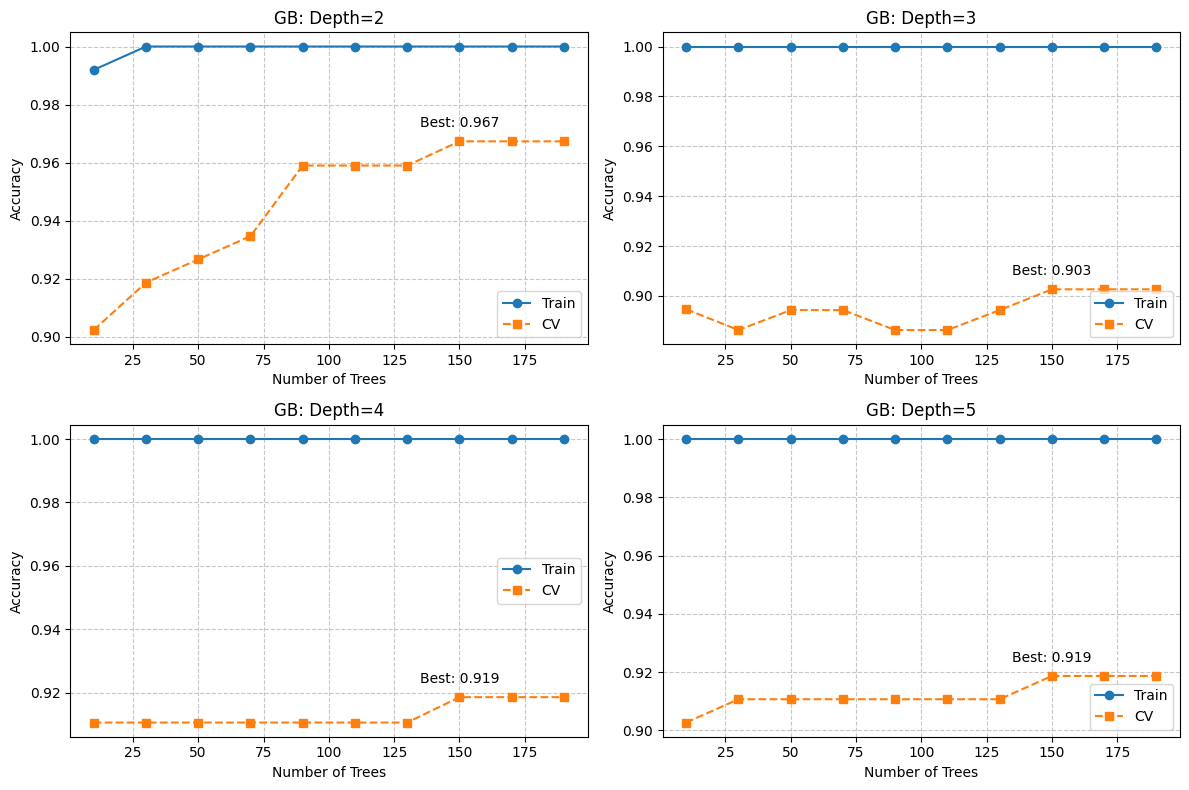

In [ ]:
# 5. Gradient Boosting Learning Curves and Parameter Selection
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# Define parameter ranges
n_estimators_list = np.arange(10, 201, 20)
depths = [2, 3, 4, 5]

plt.figure(figsize=(12, 8))

for idx, depth in enumerate(depths, 1):
    train_scores, cv_scores = [], []

    for n in n_estimators_list:
        gb = GradientBoostingClassifier(n_estimators=n, max_depth=depth,
                                       learning_rate=0.1, random_state=42)
        gb.fit(X_train, y_train)

        # Training accuracy
        train_scores.append(gb.score(X_train, y_train))

        # Cross-validation (using only training data)
        cv_score = np.mean(cross_val_score(gb, X_train, y_train, cv=5))
        cv_scores.append(cv_score)

    # Plotting
    ax = plt.subplot(2, 2, idx)
    ax.plot(n_estimators_list, train_scores, 'o-', label='Train')
    ax.plot(n_estimators_list, cv_scores, 's--', label='CV')

    # Formatting
    ax.set_title(f"GB: Depth={depth}", fontsize=12)
    ax.set_xlabel("Number of Trees", fontsize=10)
    ax.set_ylabel("Accuracy", fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend()

    # Highlight best CV score
    best_idx = np.argmax(cv_scores)
    ax.annotate(f'Best: {cv_scores[best_idx]:.3f}',
                (n_estimators_list[best_idx], cv_scores[best_idx]),
                textcoords="offset points",
                xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

6. Random Forest Analysis
  Compare OOB vs cross-validation:

- Uses OOB score (internal validation)

- Compares with 5-fold CV results

- Shows agreement between validation methods

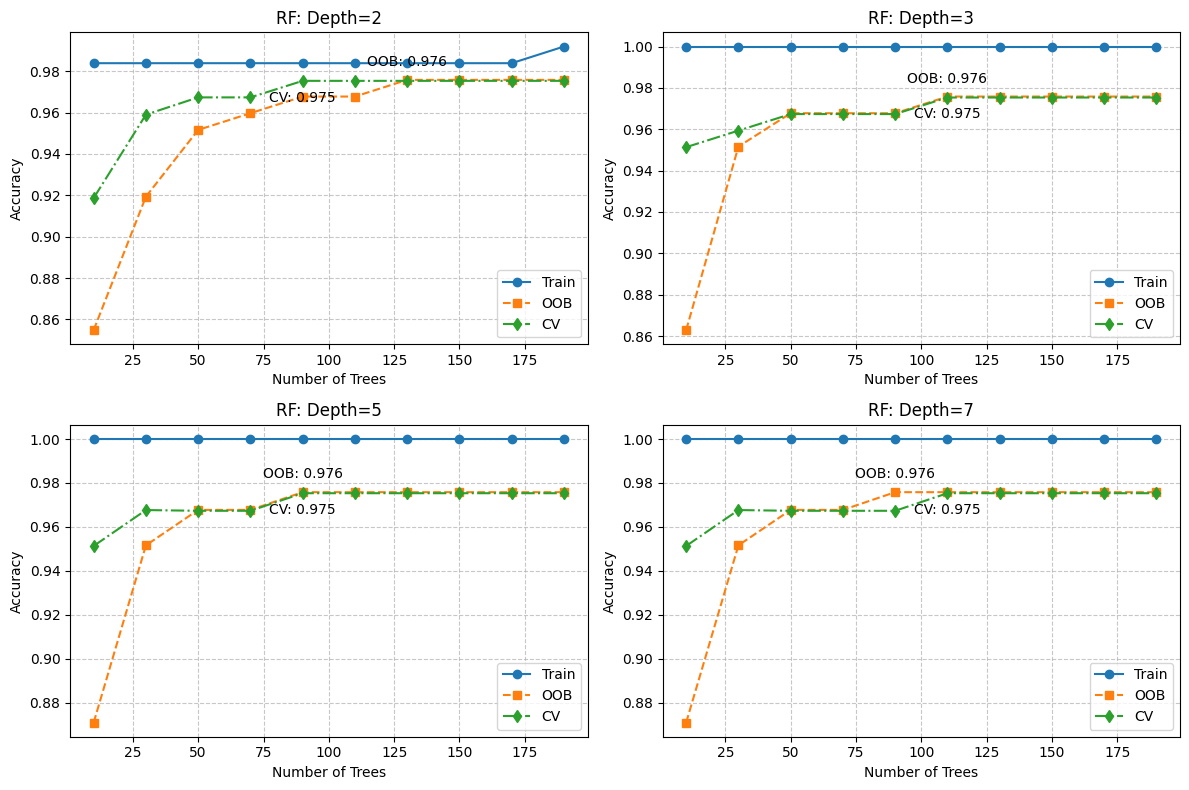

In [ ]:
# # 6. Random Forest Analysis

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Define parameter ranges
n_estimators_list = np.arange(10, 201, 20)
depths = [2, 3, 5, 7]

plt.figure(figsize=(12, 8))

for i, depth in enumerate(depths, 1):
    train_scores, oob_scores, cv_scores = [], [], []

    for n in n_estimators_list:
        rf = RandomForestClassifier(n_estimators=n, max_depth=depth,
                                  oob_score=True, random_state=42)
        rf.fit(X_train, y_train)

        # Record scores
        train_scores.append(rf.score(X_train, y_train))
        oob_scores.append(rf.oob_score_)
        cv_scores.append(np.mean(cross_val_score(rf, X_train, y_train, cv=5)))

    # Plotting
    ax = plt.subplot(2, 2, i)
    ax.plot(n_estimators_list, train_scores, 'o-', label='Train')
    ax.plot(n_estimators_list, oob_scores, 's--', label='OOB')
    ax.plot(n_estimators_list, cv_scores, 'd-.', label='CV')

    # Formatting
    ax.set_title(f"RF: Depth={depth}", fontsize=12)
    ax.set_xlabel("Number of Trees", fontsize=10)
    ax.set_ylabel("Accuracy", fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend()

    # Annotate best OOB and CV scores
    best_oob_idx = np.argmax(oob_scores)
    best_cv_idx = np.argmax(cv_scores)
    ax.annotate(f'OOB: {oob_scores[best_oob_idx]:.3f}',
                (n_estimators_list[best_oob_idx], oob_scores[best_oob_idx]),
                textcoords="offset points", xytext=(0,10), ha='center')
    ax.annotate(f'CV: {cv_scores[best_cv_idx]:.3f}',
                (n_estimators_list[best_cv_idx], cv_scores[best_cv_idx]),
                textcoords="offset points", xytext=(0,-15), ha='center')

plt.tight_layout()
plt.show()

7. Compare all methods:

- Compare optimized models.

- Uses optimal parameters from previous analysis

- Provides test set comparison

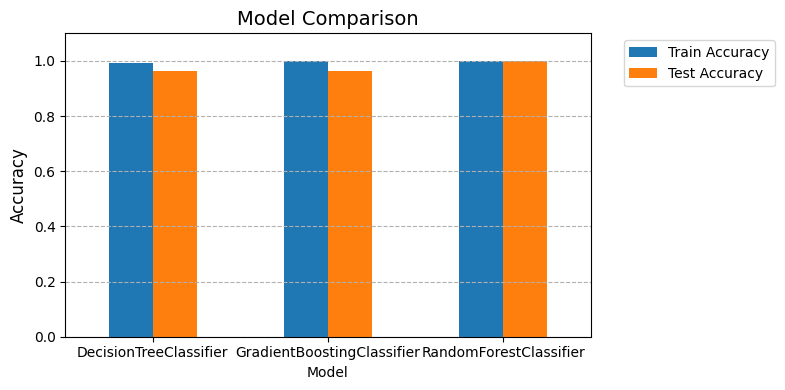


Final Model Scores:
                            Train Accuracy  Test Accuracy
Model                                                    
DecisionTreeClassifier               0.992          0.963
GradientBoostingClassifier           1.000          0.963
RandomForestClassifier               1.000          1.000


In [ ]:
# 7. Final Comparison
import pandas as pd

# Train final models
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)
rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)

# Create comparison visualization
results = []
for model in [dt, gb, rf]:
    model.fit(X_train, y_train)
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    results.append({
        'Model': model.__class__.__name__,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc
    })

# Convert to DataFrame for nice visualization
results_df = pd.DataFrame(results).set_index('Model')

# Plot results
fig, ax = plt.subplots(figsize=(8, 4))
results_df.plot(kind='bar', ax=ax, rot=0)
ax.set_title("Model Comparison", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_ylim(0, 1.1)
ax.grid(True, axis='y', linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print numerical results
print("\nFinal Model Scores:")
print(results_df.round(3))